#  AST/STAT-5731

Claudia Scarlata

## Intro to PyMC

Notes on the use of PyMC, based on a combination of the following resources:

- paper I posted on canvas,<br>
- book [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) available online,<br>
- [tutorials](https://docs.pymc.io/en/stable/nb_tutorials/index.html) on the official PyMC3 document page <br>

PyMC3 is a free python *probabilistic programming* framework tha simplifies the specification of statistical models, fitting of parameters, and analysis of posteriors. 

It includes a number of different [MC sampling algorithms](https://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html) and works well on high dimentional and complex posterior distributions. The syntax is very intuitive and mirrors the statistical notation we have been using in this course. 
PyMC3 allows fitting complex models to the data without a specialized knowledge of fitting algorithms.

## Working example
As a working simple example to understand the *basic cpabilities/structure* of PyMC3 we will use the simple Bayesian linear regression model we have been working with in class. 

We will use the Cepheid stars dataset, which include the following data points:

- MV: absolute magnitude of the star <br>
- LogP: log$_{10}$ of the variability Period (P) <br>
- [Fe/H]: iron abundance with respect to solar. 

We want to model the absolute magnitude MV as a linear function of the two predictors, LogP=X$_1$ and [Fe/H]=X$_2$. Our statistical model can be written as:

$$Y\sim N(\mu,\lambda^{-1})$$ 

where the expected value μ is a linear function of $X_1$ and $X_2$. 

$$\mu = \beta_0 +\beta_1 X_1 + \beta_2 X_2$$

Where $\beta_0$ is the intercept and $\beta_i$ are the coefficients for $X_i$.

As discussed in lecture, $\sigma$ can be interpreted as the observation (or measurement) error (the same for each measurement $Y_i$), or as the intrinsic scatter in a physical relation, possibly induced by an uknown variable.

We will use zero mean normal priors with variance of 10 to both regression parameters, β. We will also chose a half normal distribution for the variance, as the variance is positive. So:

$$\beta \sim {\rm N_3}(0,10)$$
$$\lambda \sim {\rm Gamma}(1,1)$$

## The data

We can reuse the fundamental plane data you used in your homework. 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from astropy.io import ascii
from sklearn.linear_model import LinearRegression
import arviz as az
import pymc as pm

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

'''
data = ascii.read('M_sigma.csv')

x1=data['obsx'].data
x2= data['obsx'].data*0. + np.random.randn(len(x1))
y=data['obsy'].data

'''

data = ascii.read('Cepheids_DATA_all.csv')

y=data['MV']
x1=data['LogP']
x2=data['[Fe/H]']

## Model specification in PyMc3

Specifying a statistical model in PyMC3 is very simple because the python specification follows the same syntax as the statistical notation above. Most common statistical distributions are already implemented in PyMC3, and need only to be imported.


In [5]:
from pymc import Model, Normal, Gamma, model_to_graphviz
# The following code implements the model in PyMC:

In [6]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    beta = Normal('beta', mu=0, tau=1./10, shape=3)
    precision = Gamma('precision', alpha=1, beta=1)
    # Expected value of outcome
    mu = beta[0] + beta[1]*x1 + beta[2]*x2
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

The first line:

> basic_model = Model()

creates a new Model object which is a container for the model random variables (you can learn more [here](https://www.tutorialspoint.com/python/python_classes_objects.htm) and [here](https://www.youtube.com/watch?v=yBs0ic7pVvk) about objects and classes). In simple terms, an object can be anything (a galaxy, a person, a plot). What an object is and what it can do is defined by writing a class which is a template that defines the object's attributes and methods. To bring an object to life, you first create its istance, you set its attributes and you tell it what to do. <br>
Following instantiation of the model, we need to specify its attributes (the model components). This is performed inside the **with** statement.

The **with** statement is used to manage the context initialized in **basic_model**. All objects introduced in the **with** block are added to the model. 


The following two statements create the priors of the model parameters as **stochastic** random variables with Normal distributions for the regression coefficients, and a Gamma distribution for the  precision.

```python
    beta = Normal('beta', mu=0, tau=1./10, shape=3)
    precision = Gamma('precision', alpha=1, beta=1)
```

[Here](https://docs.pymc.io/en/stable/developer_guide.html#model-context-and-random-variable) you can read a little more what it means to add a random variable to a model. 

Note: if you try to create a new random variable outside of a model context manger, the code will raise an error since there is no obvious model for the variable to be added to. PyMC3 random variables can be used outside a model, but a different syntax needs to be used. 

***
***
### Constructors of random variables (e.g., Normal)

1. The first argument for random variable constructors is always the *name* of the variable. Best practice: the name should match the name of the Python variable being assigned to, since it can be used to retrieve the variable from the model when summarizing output. 
2. The remaining required arguments for a stochastic object are the parameters. In **Normal**, in this case the parameters are the mean **mu** and the precision **tau** (don't forget to be mindful of how different softwares expects the parameters to be defined, I could have specified the standard deviation using **sd**). 
3. Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial and others, are available as PyMC3 objects, and do not need to be manually coded by the user.
4. Note that we added an additional shape argument to the constructor for the **Normal** distribution to denote it as a vector-valued parameter of size 3. The **shape** argument specifies the length or shape of the random variable.
5. Detailed notes about distributions, sampling methods and other PyMC3 functions are available via the help function.


In [7]:
print(type(beta))                           
print(basic_model.free_RVs)         


<class 'pytensor.tensor.variable.TensorVariable'>
[beta, precision]


Note that the random variable **precision** is a transformed distribution. This is done by PyMC3 automatically, in order to sample models more efficiently.

We can turn the transformation off with

```python
    precision = Gamma('precision', alpha=1, beta=1,transform=None)
```

We can also change the transformation:

```python
import pymc3.distributions.transforms as tr
    precision = Gamma('precision', alpha=1, beta=1, transform=tr.log_exp_m1)
```




After the priors, the next statement creates the expected value $\mu$ of the outcomes via the linear relationship.
```python
    mu = beta[0] + beta[1]*x1 + beta[2]*x2

```

Note that $\mu$ here is *determined* by the values of $X_i$ and the parameters. Thus it's an example of a **deterministic random variable** in PyMC3. <br>

PyMC3's random variables can be treated almost as normal variables in python: they can be added, subtracted, divided, or multiplied together to create new random variables. Mathematical functions like sum, sin, exp and some linear algebra functions are also provided.

The final line in the code defines the sampling distribution of the response data. 

```python
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)
```

This is also a stochastic variable (like, e.g., $\beta$) but it's called an **obsrved stochastic** (in PyMC3), as we are associating to it the actual observed values.   It is identical to a standard stochastic, except the **observed** argument, which passes the data to the variable. This argument indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. This line is how we are defining the likelihood of the data in the model.
The parameters **mu** and **tau** are not fixed values, but are the deterministic object **mu** and the stochastic variable **precision**.

### Model fitting

With the model specified, we can obtain a posteriori estimates of the parameters in two ways. Which one to chose  depends on the question you are trying to answer. As we discussed in class, we could either find the parameters' value tha maximizes the posterior (also called maximum a posteriori, MAP, estimate), or we can compute parameter summaries based on samples drawn from the posterior distribution using MC methods.  
We are working under the assumption that analytical solutions for the posterior estimate are not feasible, as it will be the case in most non-trivial models. 

#### MAP methods

The MAP estimate for the parameters is the mode of the posterior distribution and is found using numerical optimization methods. This is fast and easy, but only gives a point estimate (i.e., no credibility intervals) and it can be misleading when the mode is not representative of the distribution. For example when th eposterior  has multiple peaks. 

We use ```find_MAP``` in PyMC3. This function returns a dictionary of variable names. You can change the optimization algorithm and chose among those available in the **scipy.optimize** module.

In [8]:
from pymc import find_MAP
import pprint
pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model)
pp.pprint(map_estimate)


{   'beta': array([-2.00336478, -1.95324857,  0.03524779]),
    'precision': array(2.76572913),
    'precision_log__': array(1.0173043)}



#### Sampling methods

In PyMC3, to run a simulation that sample the posterior, we need to specify a **step method** object that corresponds to a particular MCMC sampling algorithm (e.g., Metropolis Hasting). PyMC3’s **step_methods** submodule contains a variety of samplers. You can see them with :

```python
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))
['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'Metropolis',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PoissonProposal',
 'Slice']
```

For models that have many continuum parameters, PyMC3's most capable step method is the gradient-based No-U-Turn Sampler (NUTS). NUTS cannot be used for discrete variables. 

In the next cell we use NUTS to sample 2000 draws from the posterior, using MAP as the starting point.<br>
Not that the sampling needs to be performed inside the context of a model.



In [9]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

with basic_model:
    start = find_MAP() 

    # draw 1000 posterior samples
    trace = pm.sample( start=start,return_inferencedata=True)

Running on PyMC v5.9.0


/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_69312/1717521084.py:13: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample( start=start,return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


The sample function runs the **step method(s)** for the given number of iterations and, by default, returns a **Trace object** containing the samples collected, in the order they were collected.  If not set via the cores kwarg, the number of chains is determined from the number of available CPU cores. The trace object is the main interface for accessing values from MCMC results. It can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable.  You can get more detailed information on the trace with help(trace). 

With PyMC3 version >=3.9 the ```return_inferencedata=True``` argument makes the sample function return an **arviz.InferenceData** object instead of a MultiTrace. InferenceData has many advantages, compared to a MultiTrace: For example it can be saved/loaded from a file, and can also carry additional (meta)data such as date/version, or posterior predictive distributions. Take a look at the [ArviZ Quickstart](https://arviz-devs.github.io/arviz/getting_started/Introduction.html) to learn more.



In [10]:
trace.posterior.dims

Frozen({'chain': 4, 'draw': 1000, 'beta_dim_0': 3})

You can also run multiple chains in parallel using the **chains** and **cores** kwargs:

In [13]:
with basic_model:
    start = find_MAP() 
    # draw 2000 posterior samples
    trace = pm.sample(cores=4, chains=6, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 2 seconds.


**trace** is a [az.InferenceData](https://arviz-devs.github.io/arviz/schema/schema.html#schema) object.

A variable inside the object is a multidimensional labeled array representing a quantity. Variables can have attributes that descibe it.  Important ones are: <br>
- Dimensions: the dimensions and their named axes. In the example: 
chain: 6, draw: 1000, beta_dim_0: 3) 
- Coordinates: A named array that labels a dimension.
- Attribute: An ordered dictionary that can store arbitrary metadata.

In the **trace** object, the posterior samples from the posterior distribution. **sample_stats** contains information and diagnostics for each posterior sample, provided by pymc3. **posterior_predictive** includes the posterior predictive samples p(y|y) corresponding to the posterior predictive distribution evaluated at **the observed_data**. **Observed data** on which the posterior is conditional. 

This [link](https://arviz-devs.github.io/arviz/getting_started/WorkingWithInferenceData.html) is quite useful to learn how to work with InferenceData objects.

In [14]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [15]:
# Get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 6, draw: 1000, beta_dim_0: 3)
Coordinates:
  * chain       (chain) int64 0 1 2 3 4 5
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1 2
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -1.932 -2.044 ... -0.5103
    precision   (chain, draw) float64 2.858 2.857 2.785 ... 2.56 2.879 2.867
Attributes:
    created_at:                 2023-11-01T15:35:07.038212
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0
    sampling_time:              2.319809913635254
    tuning_steps:               1000

In [16]:
print(trace.posterior["beta"].shape)
# get values of a single chain
print(trace.posterior["beta"].sel(chain=1).shape)

(6, 1000, 3)
(1000, 3)


The posterior consists of 3 variables over 6 chains. In addition, it is a hierarchical model where values for the variable theta are associated with a particular school.

According to the xarray’s terminology:

Data variables are the actual values generated from the MCMC draws
Dimensions are the axes on which refer to the data variables
Coordinates are pointers to specific slices or points in the xarray.Dataset
Observed data from the eight schools model can be accessed through the same method.

### Posterior analysis

The most common used plot to analyze sampling results is the so-called trace-plot, that can be visualized using the arviz module **plot_trace**.

A list of many useful arviz plots can be found [here](https://arviz-devs.github.io/arviz/api/plots.html#plot-api).

On the left, we have a Kernel Density Estimation (KDE) plot; this is a smooth version of the histogram of the chain. On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior. You can compare these results using PyMC3 with those from the previous lecture, which we obtained analytically with the MLE. 

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>]], dtype=object)

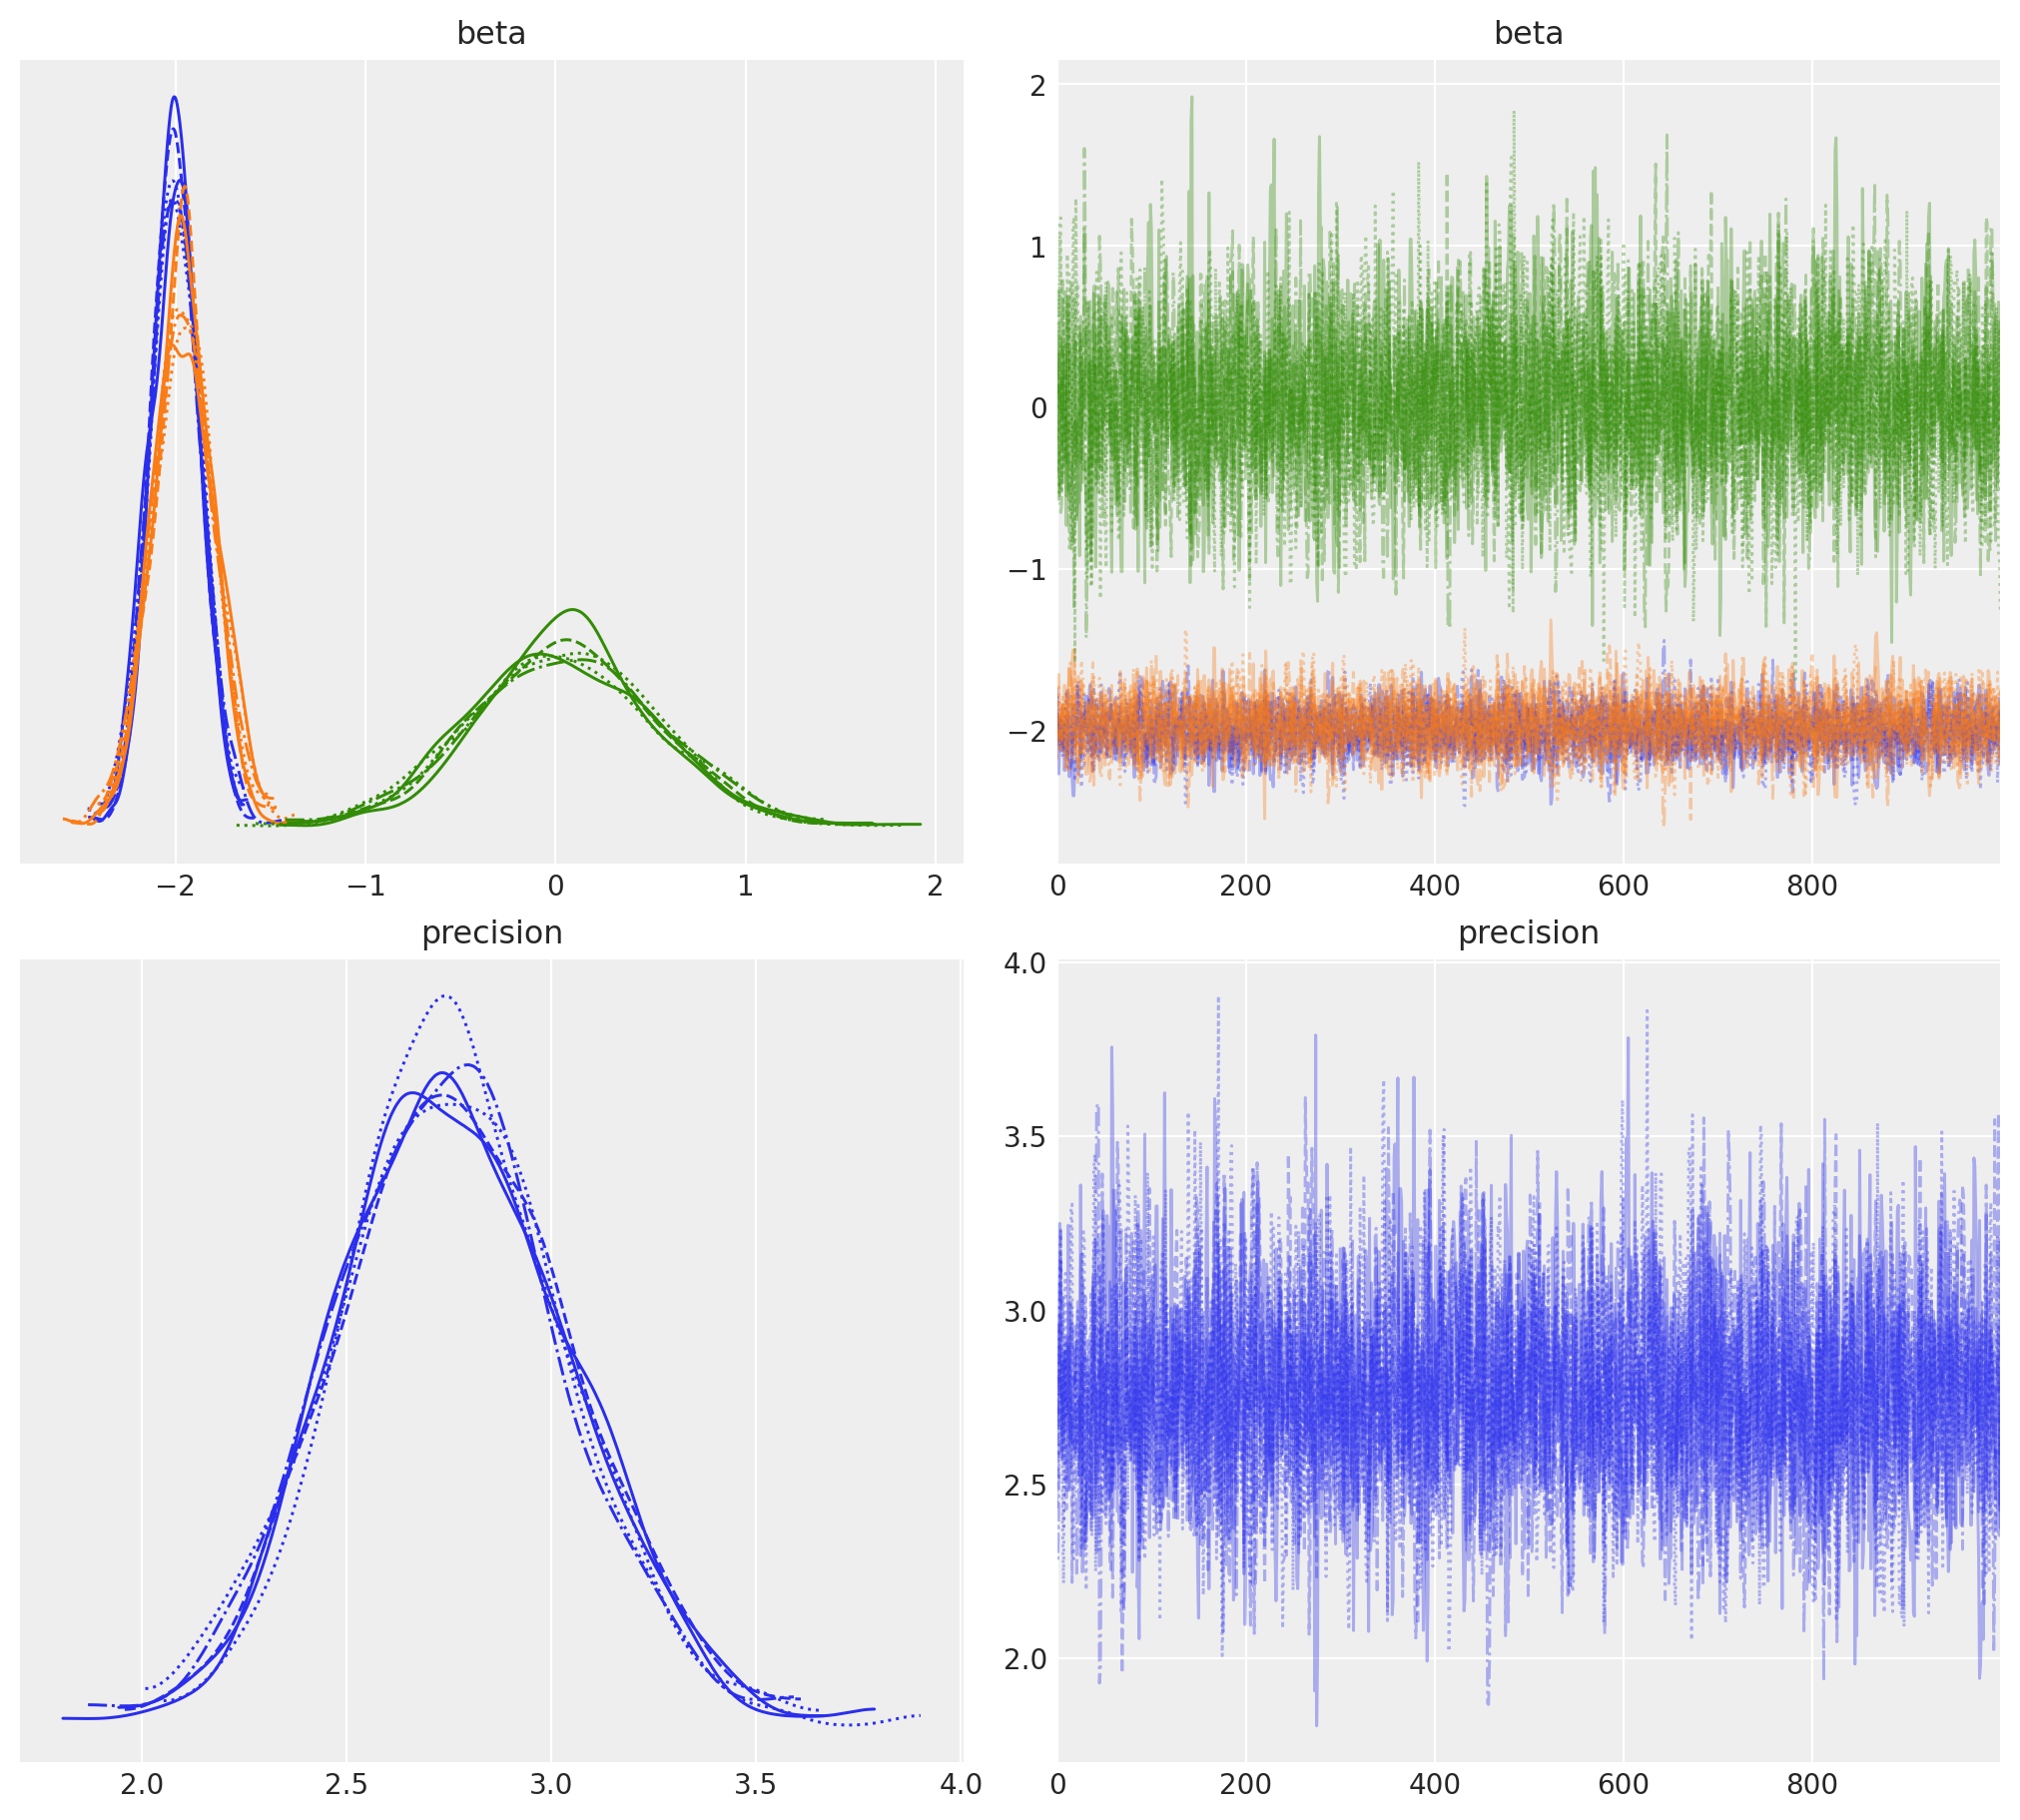

In [17]:
az.plot_trace(trace,figsize=(10, 9))

For a tabular summary, the **az.summary** function provides a text-based output of common posterior statistics. Another common metric to look at is R-hat, also known as the Gelman-Rubin statistic.

In [18]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-2.001,0.130,-2.252,-1.765,0.002,0.002,3085.0,3146.0,1.0
beta[1],-1.957,0.163,-2.257,-1.647,0.003,0.002,3037.0,3358.0,1.0
beta[2],0.046,0.479,-0.836,0.954,0.007,0.007,4356.0,3468.0,1.0
precision,2.760,0.278,2.276,3.317,0.004,0.003,3970.0,3210.0,1.0


By default, plot_posterior shows a histogram for discrete variables and KDEs for continuous variables. We also get the mean of the distribution (we can ask for the median or mode using the point_estimate argument) and the 94% HDI

HPD as a black line at the bottom of the plot. Different interval values can be set for the HPD with the credible_interval argument. Note:  Highest-Posterior Density ( HPD ) interval. An HPD is the shortest interval containing a given portion of the probability density. Commonly-used  to summarize the spread of a posterior distribution.



array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>,
       <Axes: title={'center': 'precision'}>], dtype=object)

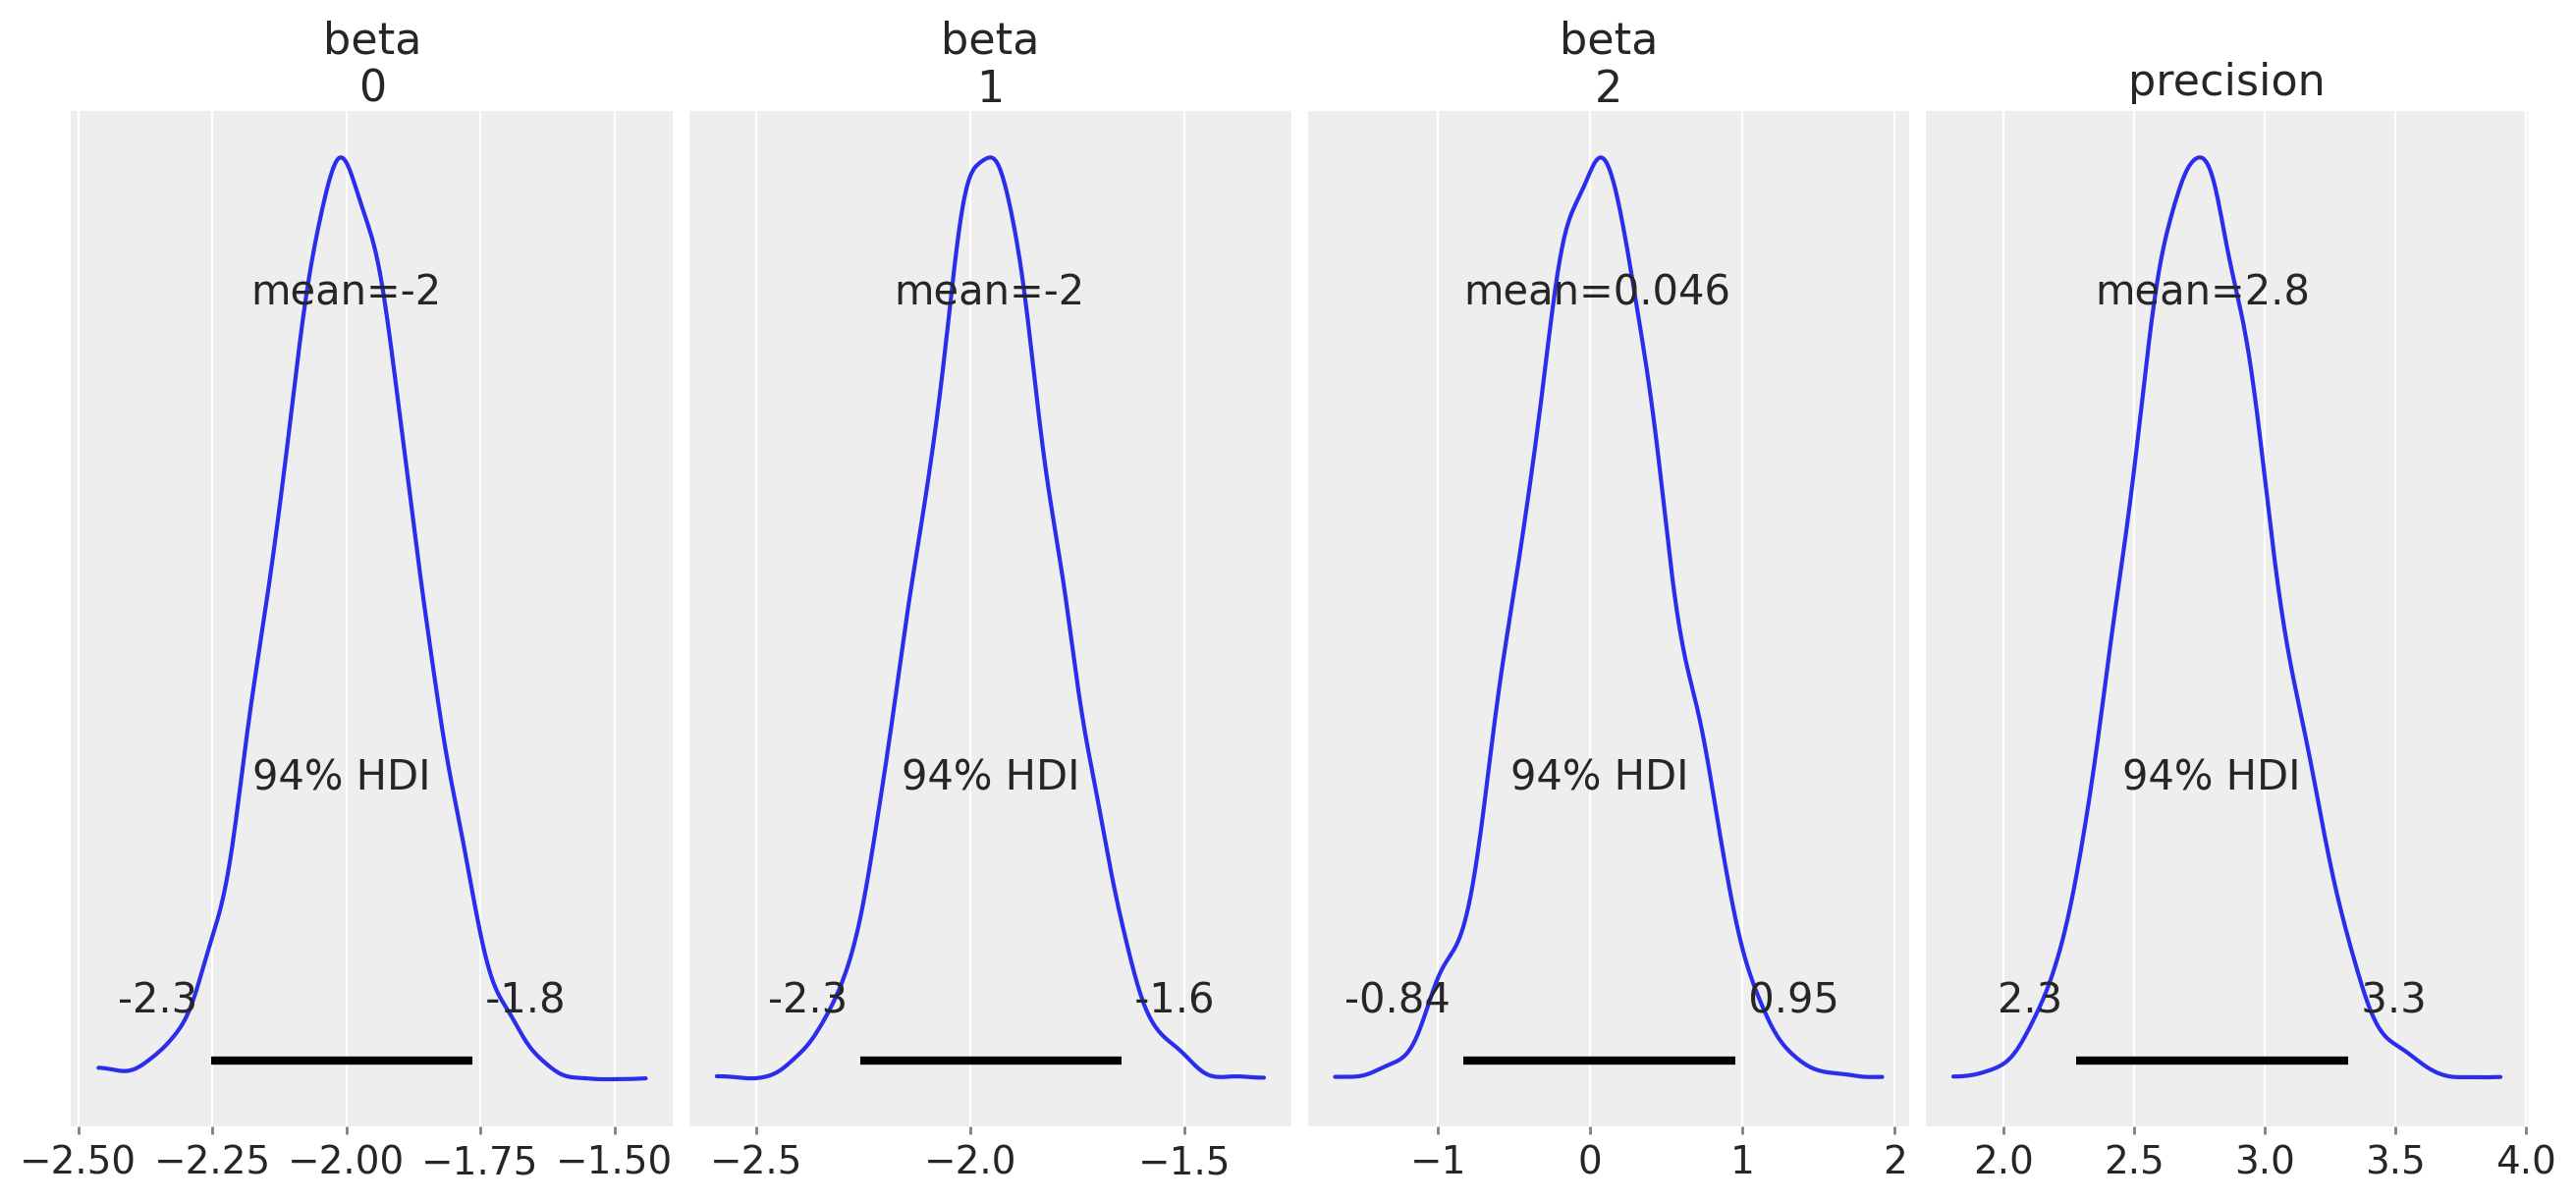

In [19]:
az.plot_posterior(trace,figsize=(13, 6))

We can calculate estimates of the effective sample size (ESS) with [**arxiz.ess**](https://arviz-devs.github.io/arviz/api/generated/arviz.ess.html#arviz.ess).

In [20]:
print(az.ess(trace,var_names=['precision']))


<xarray.Dataset>
Dimensions:    ()
Data variables:
    precision  float64 3.97e+03


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>], dtype=object)

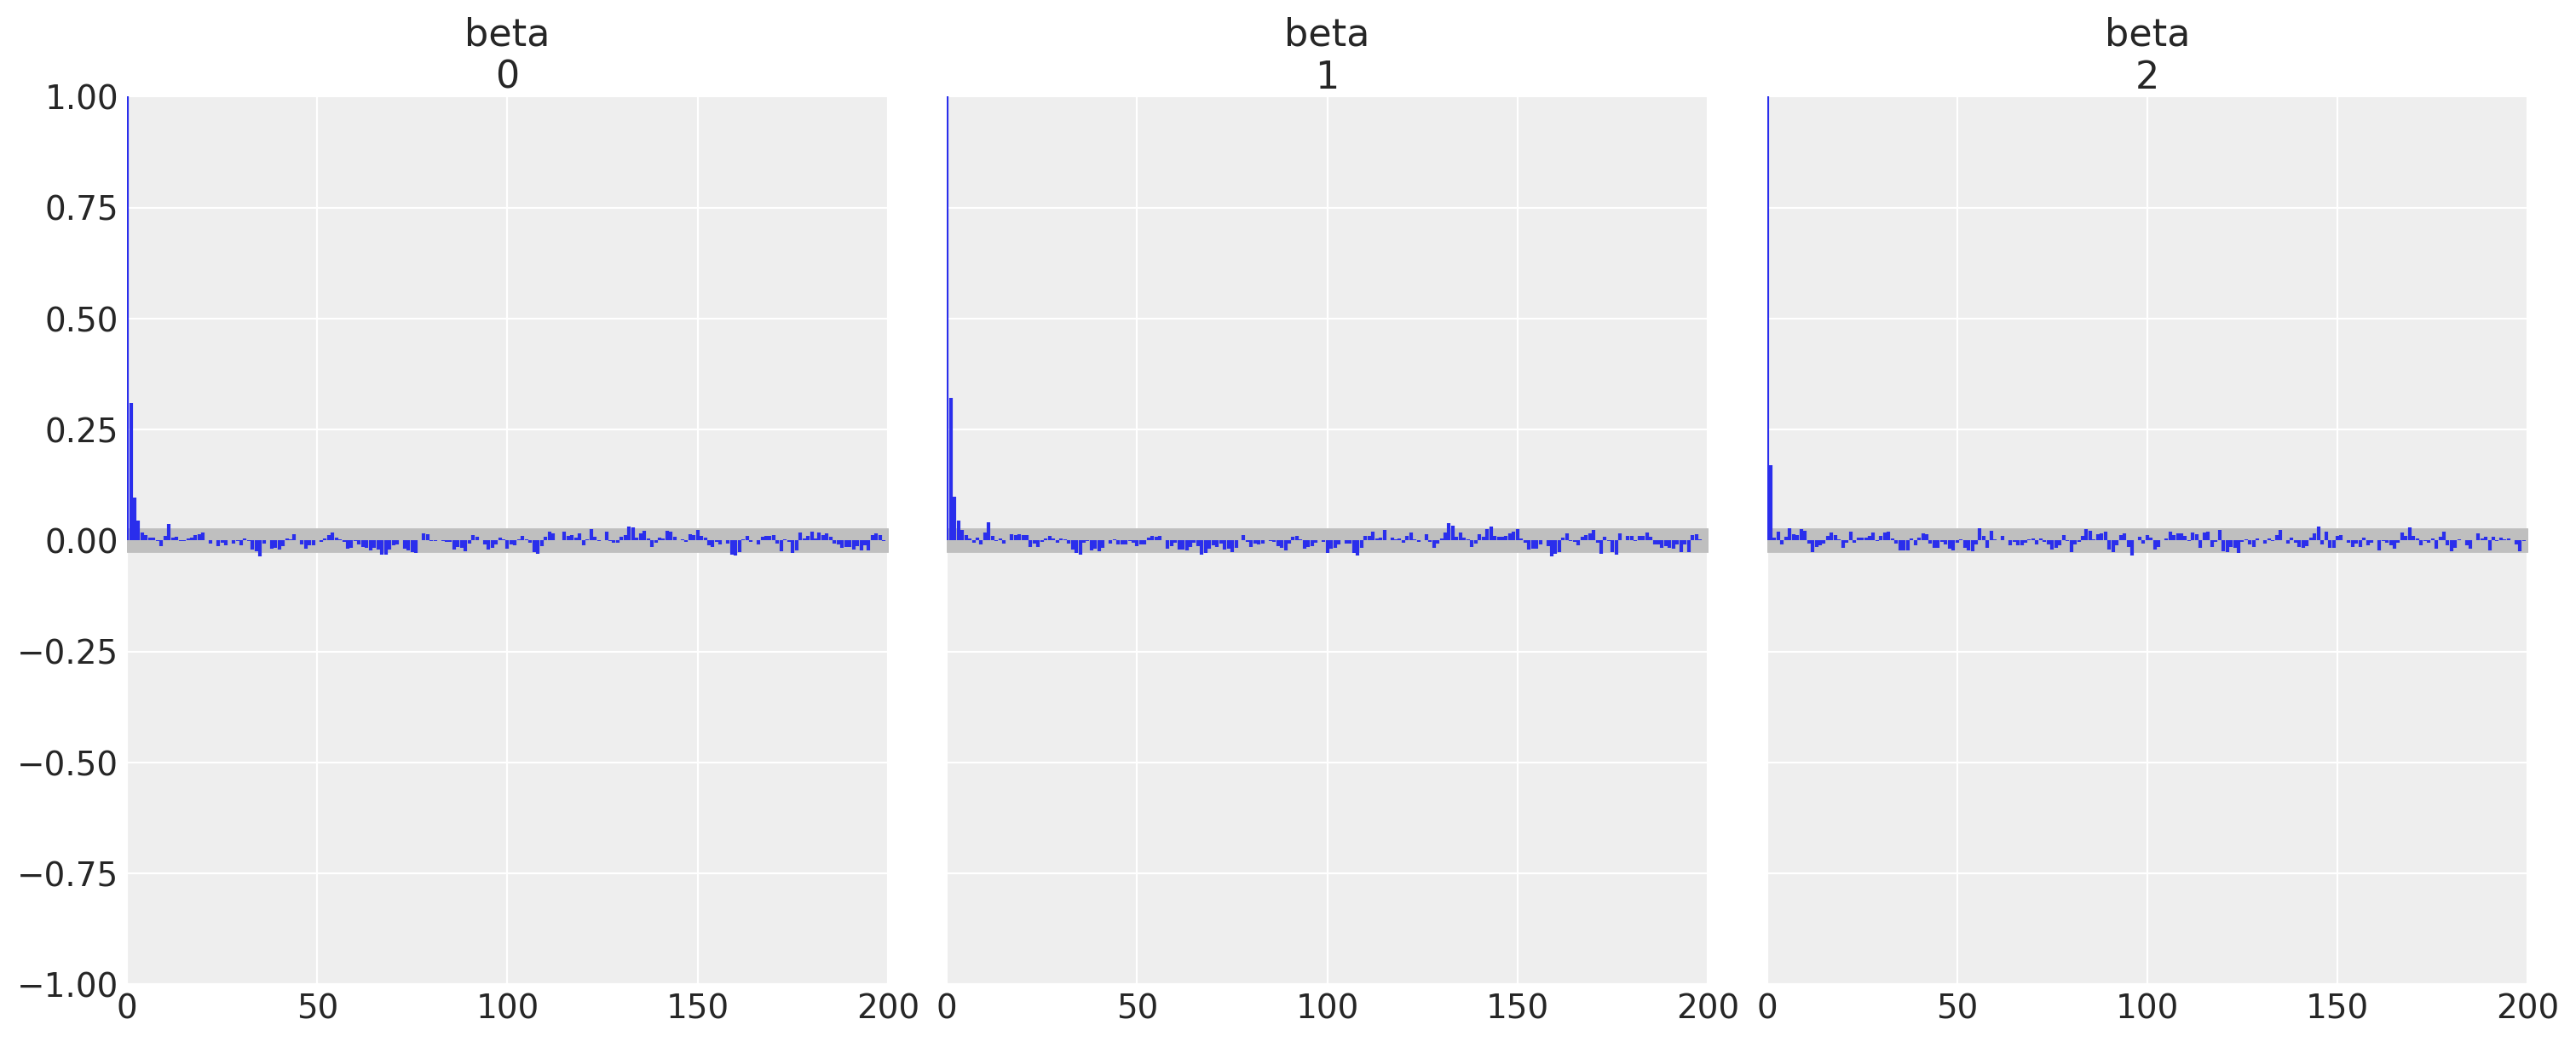

In [21]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))


## Posterior Predictive Sampling

The sample_posterior_predictive() function performs prediction on hold-out data and posterior predictive checks.

[here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html)

In [22]:
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [Y_obs]


<xarray.Dataset>
Dimensions:      (chain: 6, draw: 1000, Y_obs_dim_2: 203)
Coordinates:
  * chain        (chain) int64 0 1 2 3 4 5
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 0 1 2 3 4 5 6 ... 197 198 199 200 201 202
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 -4.156 -4.227 ... -4.888
Attributes:
    created_at:                 2023-11-01T15:35:19.754210
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0

In [24]:
print(basic_model)

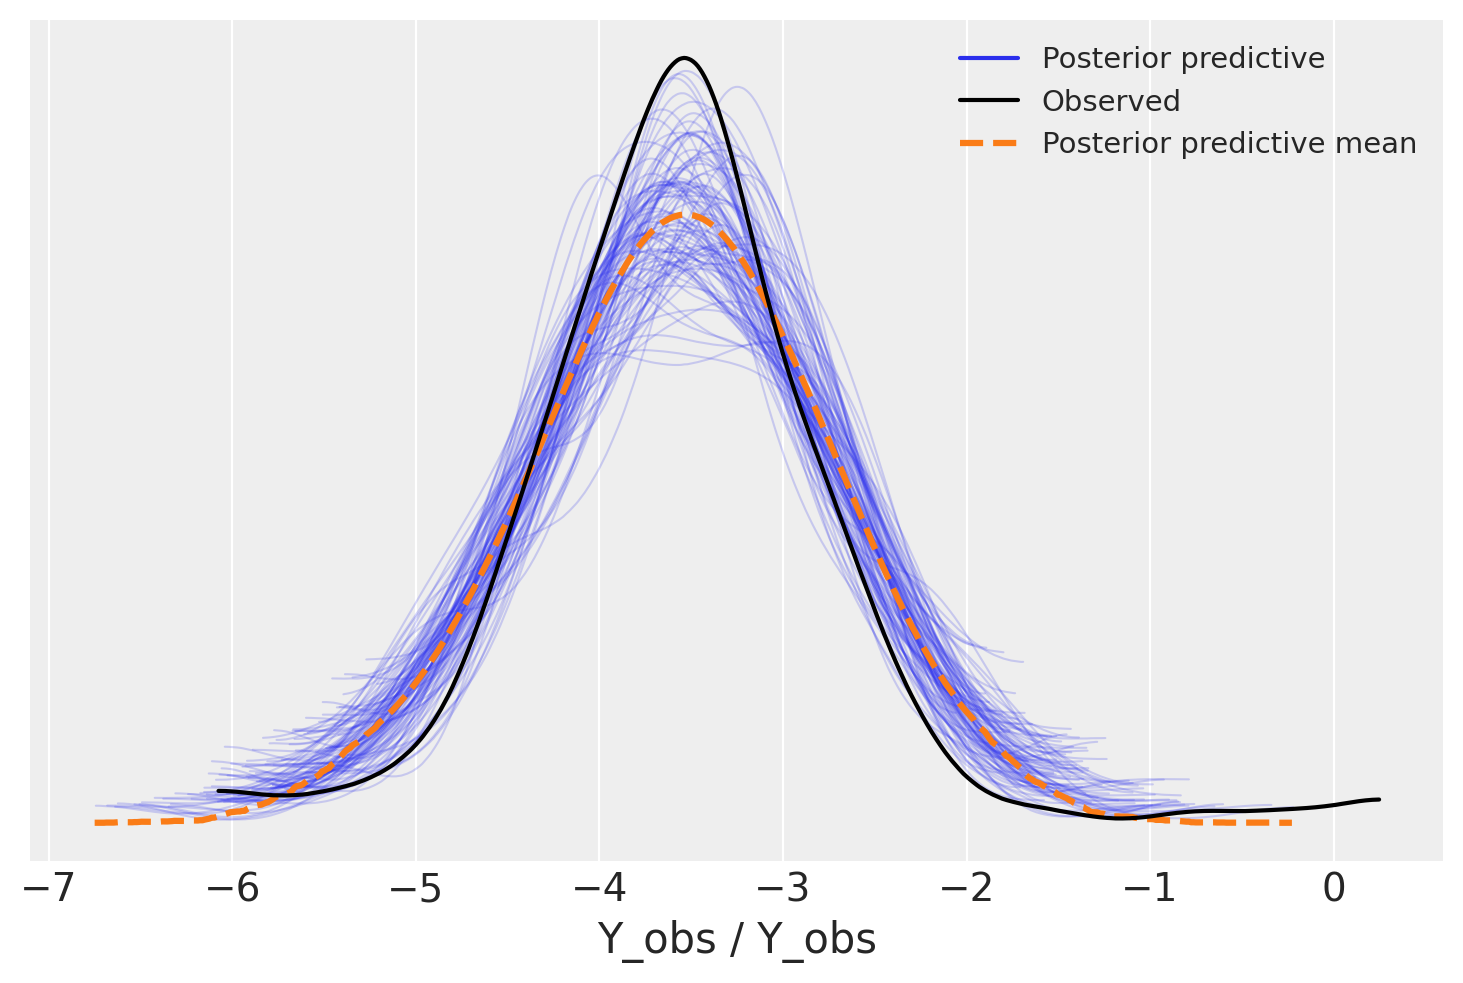

In [25]:
az.plot_ppc(trace, num_pp_samples=100);

### Getting Predictions

When performing regression analysis, getting predictions at different positions is not as straightforward as in scikit-learns fit-predict paradigm. It’s still easy, and you can create a model with changeable inputs as follows (taken from [here](https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211)): 

```python

with pm.Model() as predictive_model:
    a = pm.Normal('slope', 0, 16)
    b = pm.Normal('intercept', 0, 16)
    s = pm.Exponential('error', 1)
    
    x_ = pm.Data('features', x) # a data container, can be changed
    
    obs = pm.Normal('observation', a*x_ + b, s, observed=y)
    
    trace = pm.sample()
```

Marked in bold the changes that are needed with respect to the usual regression model. It’s basically telling the model to use a placeholder x_ which was initially filled with our training data x. We then train the model, i.e. get posterior distributions for all of the parameters. We can pass the model new data via:


```python
x_new = np.linspace(-3, 3, 50) # 50 input values between -3 and 3
with predictive_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)
```
This is basically all you have to do! To have a better understanding, let us check what’s inside ```posterior```: It’s a dictionary that contains the new observations. Let’s grab them and store them as ```y_pred```.

```python 
y_pred = posterior['observation']
```


In [27]:
with pm.Model() as predictive_model:
    a = pm.Normal('slope', 0, 16)
    b = pm.Normal('intercept', 0, 16)
    s = pm.Exponential('error', 1)
    
    x_ = pm.Data('features', [x1,x2]) # a data container, can be changed
    
    obs = pm.Normal('observation', a*x_ + b, s, observed=y)
    
    trace = pm.sample()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


ValueError: Size length is incompatible with batched dimensions of parameter 0 Add.0:
len(size) = 1, len(batched dims Add.0) = 2. Size length must be 0 or >= 2